In [4]:
# Import some libraries from python and set some defaults
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
# from scipy.interpolate import CubicSpline
import pickle
import copy
from DEq_Solver import DEq_Solver
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')

In [29]:
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="SC 4";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve') or os.path.isfile('.choices.shelve.dir'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None

def make_value_change_fn(assessmentName,name):
    def fn(change):
        s=shelve.open('.choices.shelve')
        key='{0}_{1}'.format(assessmentName,name)
        s[key]=change['new']
        s.close()
    return fn
 
class myFloatBox:
    def __init__(self,name,description,long_description):
        self.name=name
        self.description=description
        self.long_description=long_description
    def getWidget(self):
        self.widgets=[ 
              widgets.FloatText(
              description=self.description,
        disabled=False,
                  value=get_last_value('{0}_{1}'.format(assessmentName,self.name))
        )]
        
        txt=widgets.HTMLMath(
            value=self.long_description,
            placeholder='',
            description='',
        )
        
        self.widget=VBox([txt]+self.widgets)
        self.widgets[0].observe(make_value_change_fn(assessmentName,self.name), names='value')

        return self.widget
    



# Preamble: workshop notebooks

Work through this notebook cell by cell.

When working on your solution, you can save the notebook as many times as you like. You can also submit 
as many times as you like. In fact, it is a good idea to save and submit often.

**Validate** the notebook before submitting. Use the *validate* button in the browser

**Do not copy or delete one of the original cells**. Doing so means you cannot validate the notebook.
If required, *create a new cell*, and copy the *contents* of another cell.


**Only the last submission before the deadline** will be marked.
Note that you have to **submit** at least once for your work to be marked.

The notebook contains cells with code. Some of the code is (intentionally) missing. Please insert appropriate code below the line 'YOUR CODE HERE'. Cells which do not contain any 'YOUR CODE HERE' lines will allow you to test your code; if they return an error there is something wrong with your implementation; if they do not return an error your code might be correct (it is unfortunately not possible to check for every possible error).

Note:

simply add numerical value in a dropbox for it to get marked

when asked for true/false in a box:

ticking a box means True
not ticking (or ticking an even number of times) yields False


## Workshop IV: Chaos

This workshop looks at chaotic systems and analyses them in terms of Poincare sections.

The `Euler-Cromer` integrator and the equations describing a `non-linear pendulum` are taken from the previous workshops.



Example of period doubling taken from http://galileoandeinstein.phys.virginia.edu/7010/CM_22a_Period_Doubling_Chaos.html

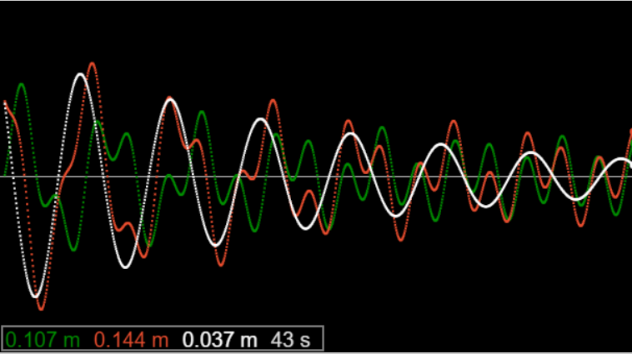

We use the same notation as in the Harmonic Motion assignment: the coordinates of a pendulum are the angle measured from the vertical ($\theta$ in the notes), and its time derivative ($\dot\theta\equiv d\theta/dt$). In the implementation below, $\theta$ and $\dot\theta$ are the first and second entry of the state vector $x$:

` x=np.array([theta, d(theta)/dt]) `

The first few cells are identical to the previous notebook, to make sure that the integrator you've developed gives the right answer.


 
 We will use the `Pendulum` class as a kernel for the standard `Euler` and `Runge-Kutta` methods, as well as for the new `Euler-Cromer` method. We will implement `dx_dt(self,x,t)` for the former and `dx_dt_EC(self,x,t)` for the latter. You have access to


    x        - the state vector
    t        - the time
    self.delta_t  - the time step
    
    self.L        - pendulum's length
    self.g        - gravity acceleration
    self.FD       - driving acceleration
    self.OD       - driving frequency
    self.q        - friction coefficient
    self.nolin    - whether pendulum is linear (small angle approximation)
    
You can copy your answers from the previous workshop    


In [6]:
# physical constants used below, g is average gravitational acceleration on Earth's surface
phys_const = {'g':9.81}  # units [m/s^2]

In [7]:
class Pendulum:
    def __init__(self, L, q=0, F_D=0, Omega_D=0, nonlinear=False):
        """Initialize a pendulum object with 
        length L [m], 
        friction coefficient q [1/s],  
        driving acceleration amplitude F_D [N/kg],
        frequency Omega_D [s^-1]. 
        and a boolean switch to enable the nonlinear pendulum"""
        self.L      = float(L)
        self.q      = float(q)
        self.FD     = float(F_D)
        self.OD     = float(Omega_D)
        self.nonlin = nonlinear
        self.g      = phys_const["g"]             # gravitational acceleration on the Earth's surface [m/s^2]

    def dx_dt(self,x,t):
        ''' Calculate the time derivative for 
              - the position, x[0]=theta
              - the angular velocity, x[1]=dtheta/dt
         Note that angles are assumed to be in *radians*
         Include gravity, friction and driving
         Implement both linear (small-angle) and non-linear (no small-angle approximation) cases
         Input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
               note: input x should be in the form of a numpy array
         Returns: dx/dt = [dtheta/dt, d^2theta/dt^2]: speed and acceleration of the pendulum
         Note that the function should return dx/dt as an numpy array '''
        # YOUR CODE HERE
        theta, dtheta_dt = x
        
        if self.nonlin:
            # Compute U for the non-linear case
            d2theta_dt2 = - (self.g / self.L) * np.sin(theta)
        else:
            # Compute U for the linear (small angle) case
            d2theta_dt2 = - (self.g / self.L) * theta
       
        # Add damping and driving force
        d2theta_dt2 = d2theta_dt2 - self.q * dtheta_dt + self.FD * np.sin(self.OD * t)
        
        return np.array([dtheta_dt, d2theta_dt2])


In [8]:
# Test the dx_dt implementation
testPend=Pendulum(2.3,1.1,0.5,2.2,False)
testPendNL=Pendulum(2.3,1.1,0.5,2.2,True)

test1 = np.isclose(testPendNL.dx_dt([0.5,0.3],0.7),[ 0.3, -1.87509123]).all()
test2 = np.isclose(testPend.dx_dt([0.5,0.3],0.7),[ 0.3, -1.96284578]).all()
if not test2:
    print("There is an error in your pendulum implementation")
if not test1:
    print("There is an error in your non-linear pendulum implementation")
if test1 & test2:
    print("Your implemention of the pendulum looks OK")

Your implemention of the pendulum looks OK


In [9]:
class EulerCromerSolver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        ''' Implement the EC step, as before you have access to
         time as self.t
         the time step as self.delta_t
         the position and velocity as the vector self.x
         the derivative of x, dx/dt, as the kernel self.kernel.dx_dt
         output: none
         makeStep changes the state vector
           - updates time using the time step
           - updates the state vector x, given its time derivative, kernel.dx_dt
         make sure you update position and velocity in the manner consistent with the Euler-Cromer method '''
        # YOUR CODE HERE
        dtheta_dt, d2theta_dt2 = self.kernel.dx_dt(self.x,self.t)
        self.x[1] += self.delta_t * d2theta_dt2
        self.x[0] += self.delta_t * self.x[1]
        self.t += self.delta_t

In [10]:
# Test the EC step
testEC=EulerCromerSolver(testPend)
testEC.x=[0.3,0.2]
testEC.t=0
testEC.delta_t=0.01
testEC.makeStep()
test1 = np.isclose(testEC.t,0.01)
test2 = np.isclose(testEC.x,[ 0.30185004,  0.18500435]).all()

if not test1:
    print("There is an error in the value of t for your EC implementation")
if not test2:
    print("There is an error in the value of x for your EC implementation")
if test1 & test2:
    print("Your EC implementation looks OK")

Your EC implementation looks OK


## Evolution of the non-linear driven pendulum

Below we compute the evolution of the non-linear pendulum. Use the following parameters (length `L`, friction coefficient `q`, driving frequency `Omega_D`, initial time `t0`, final time `t1`, all in SI units)

` - L = 9.81, q = 0.5, Omega_D = 2./3.`

` - t0 = 0, t1 = 150`

` - nonlinear = True`

Compute the evolution for two values of the driving acceleration $F_D$, taking $F_D=0.5$ and $F_D=1.2$.

For each of these, calculate the evolution from $\theta_0=0.2$, the launch angle in radians,
as well as for a small difference $\Delta \theta_0=1\times 10^{-3}$ from $\theta_0$.
  

Plot $\theta(t)$ for these four cases using the cell below. Use different colours and different linestyles to distinguish the curves. Annotate the axis and provide a legend.

In the right-hand-plot, you will see discontinuities in $\theta(t)$. What are these?
To make the plot look smoother, it makes sense to plot $\sin(\theta)$, rather than $\theta$.
Try both options. Consider which is the best way to visualize your results.

Compare your plot to my result and convince yourself that your solution looks similar.
I used a timestep of dt=0.04

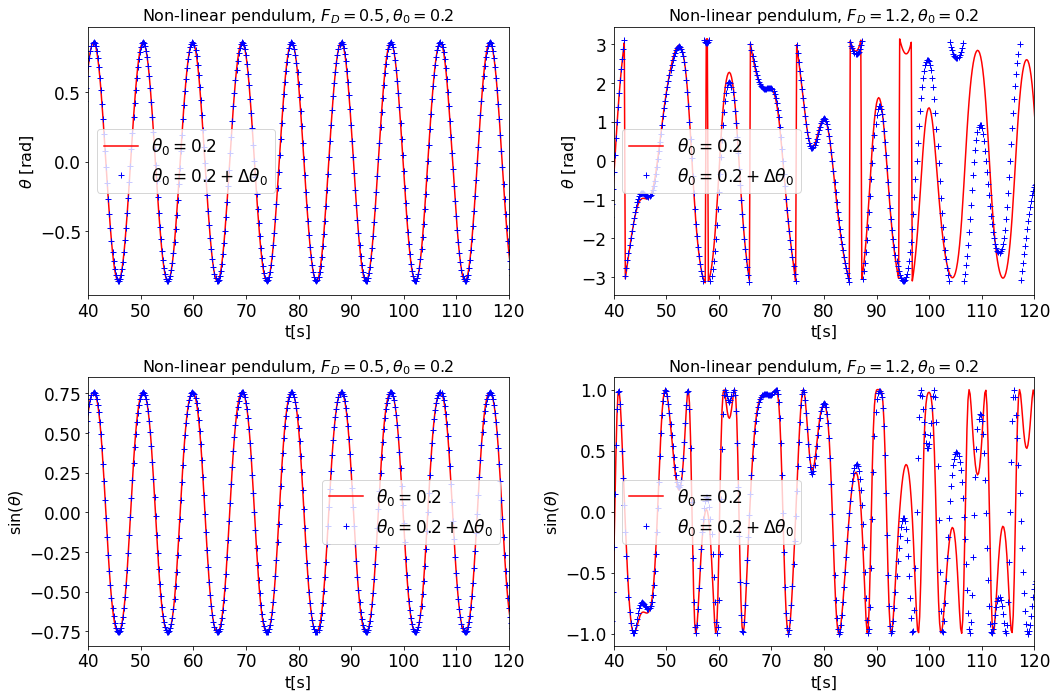

In [22]:
# Make a four panel plot, 2 panels x 2 panels
# Top panels
# Top left: theta(t) for F_D = 0.5, showing the case with launch angle theta0, and launch angle theta_0+dtheta_0
#           use different colours or line-styles to distinguish them. Add a legend
# Top right: same, but for F_D=1.2

# Lower panels: same as top panels, but plotting sin(theta(t))

# Use a pendulum with these parameters
L          = 9.81
q          = 0.5       # Friction coefficient
Omega_D    = 2./3.     # Driving frequency (1/s)
Period     = 2*np.pi / Omega_D # Driving period (s)
nonlinear  = True      
t0         = 0          # Start time (s)
t1         = 150        # End time (s)
dt         = 0.04       # Time-step (s)
theta0     = 0.2        # launch (initial) angle in radians
dtheta0    = 1e-3       # small difference in launch angle in radians

# Approximate marking scheme
# 2 x 2 panels:                                      2 marks
# upper panels plot theta(t) vs t:                   2 marks
#    the two cases are distinguished in the legend   2 marks
# lower panels plot sin(theta) vs t:                 2 marks
# the curves look OK                                 2 marks
# YOUR CODE HERE

F_D_values = [0.5, 1.2]

fig, ax = plt.subplots(2, 2, figsize = (15, 10))

for i, F_D in enumerate(F_D_values):
    pendulum1 = Pendulum(L, q, F_D, Omega_D, nonlinear)
    pendulum2 = Pendulum(L, q, F_D, Omega_D, nonlinear)
    
    x0_1 = np.array([theta0, 0])
    x0_2 = np.array([theta0 + dtheta0, 0])
    
    solver1 = EulerCromerSolver(pendulum1)
    solver2 = EulerCromerSolver(pendulum2)
    
    solver1.solve(x0_1, t0, t1, dt)
    solver2.solve(x0_2, t0, t1, dt)
    
    ts1 = solver1.timeSteps()
    ts2 = solver2.timeSteps()
    theta1, _ = solver1.coordinateSteps()
    theta2, _ = solver2.coordinateSteps()
    theta1 = (theta1 + np.pi) % (2 * np.pi) - np.pi
    theta2 = (theta2 + np.pi) % (2 * np.pi) - np.pi
    
    ax[0, i].plot(ts1[::5], theta1[::5], '-', color='r', label=r"$\theta_0=0.2$")
    ax[0, i].plot(ts2[::5], theta2[::5], '+', color='b', label=r"$\theta_0=0.2 + \Delta \theta_0$")
    ax[0, i].set_xlabel('t[s]')
    ax[0, i].set_ylabel(r'$\theta$ [rad]')
    ax[0, i].legend()
    ax[0, i].set_title(f"Non-linear pendulum, $F_D = {F_D},θ_0 = {theta0}$")
    ax[0, i].set_xlim([40,120])
    
    ax[1, i].plot(ts1[::5], np.sin(theta1)[::5], '-', color='r', label=r"$\theta_0=0.2$")
    ax[1, i].plot(ts2[::5], np.sin(theta2)[::5], '+', color='b', label=r"$\theta_0=0.2 + \Delta \theta_0$")
    ax[1, i].set_xlabel('t[s]')
    ax[1, i].set_ylabel(r'$\sin(\theta)$')
    ax[1, i].legend()
    ax[1, i].set_title(f"Non-linear pendulum, $F_D = {F_D},θ_0 = {theta0}$")
    ax[1, i].set_xlim([40,120])

plt.tight_layout()
plt.show()
    

You may want to compare your result to the one I obtained.
Note how individual panels have the value of $F_D$ and $\theta_0$ in their title  
and the use of a legend to distinguish the value of $\Delta\theta_0$.

Also notice the use of a line for $\Delta\theta_0=0$ and symbols for $\Delta\theta_0>0$ for easy comparison.
How to make sure there are not too many crosses, which would cause the red crosses to hide the blue line?

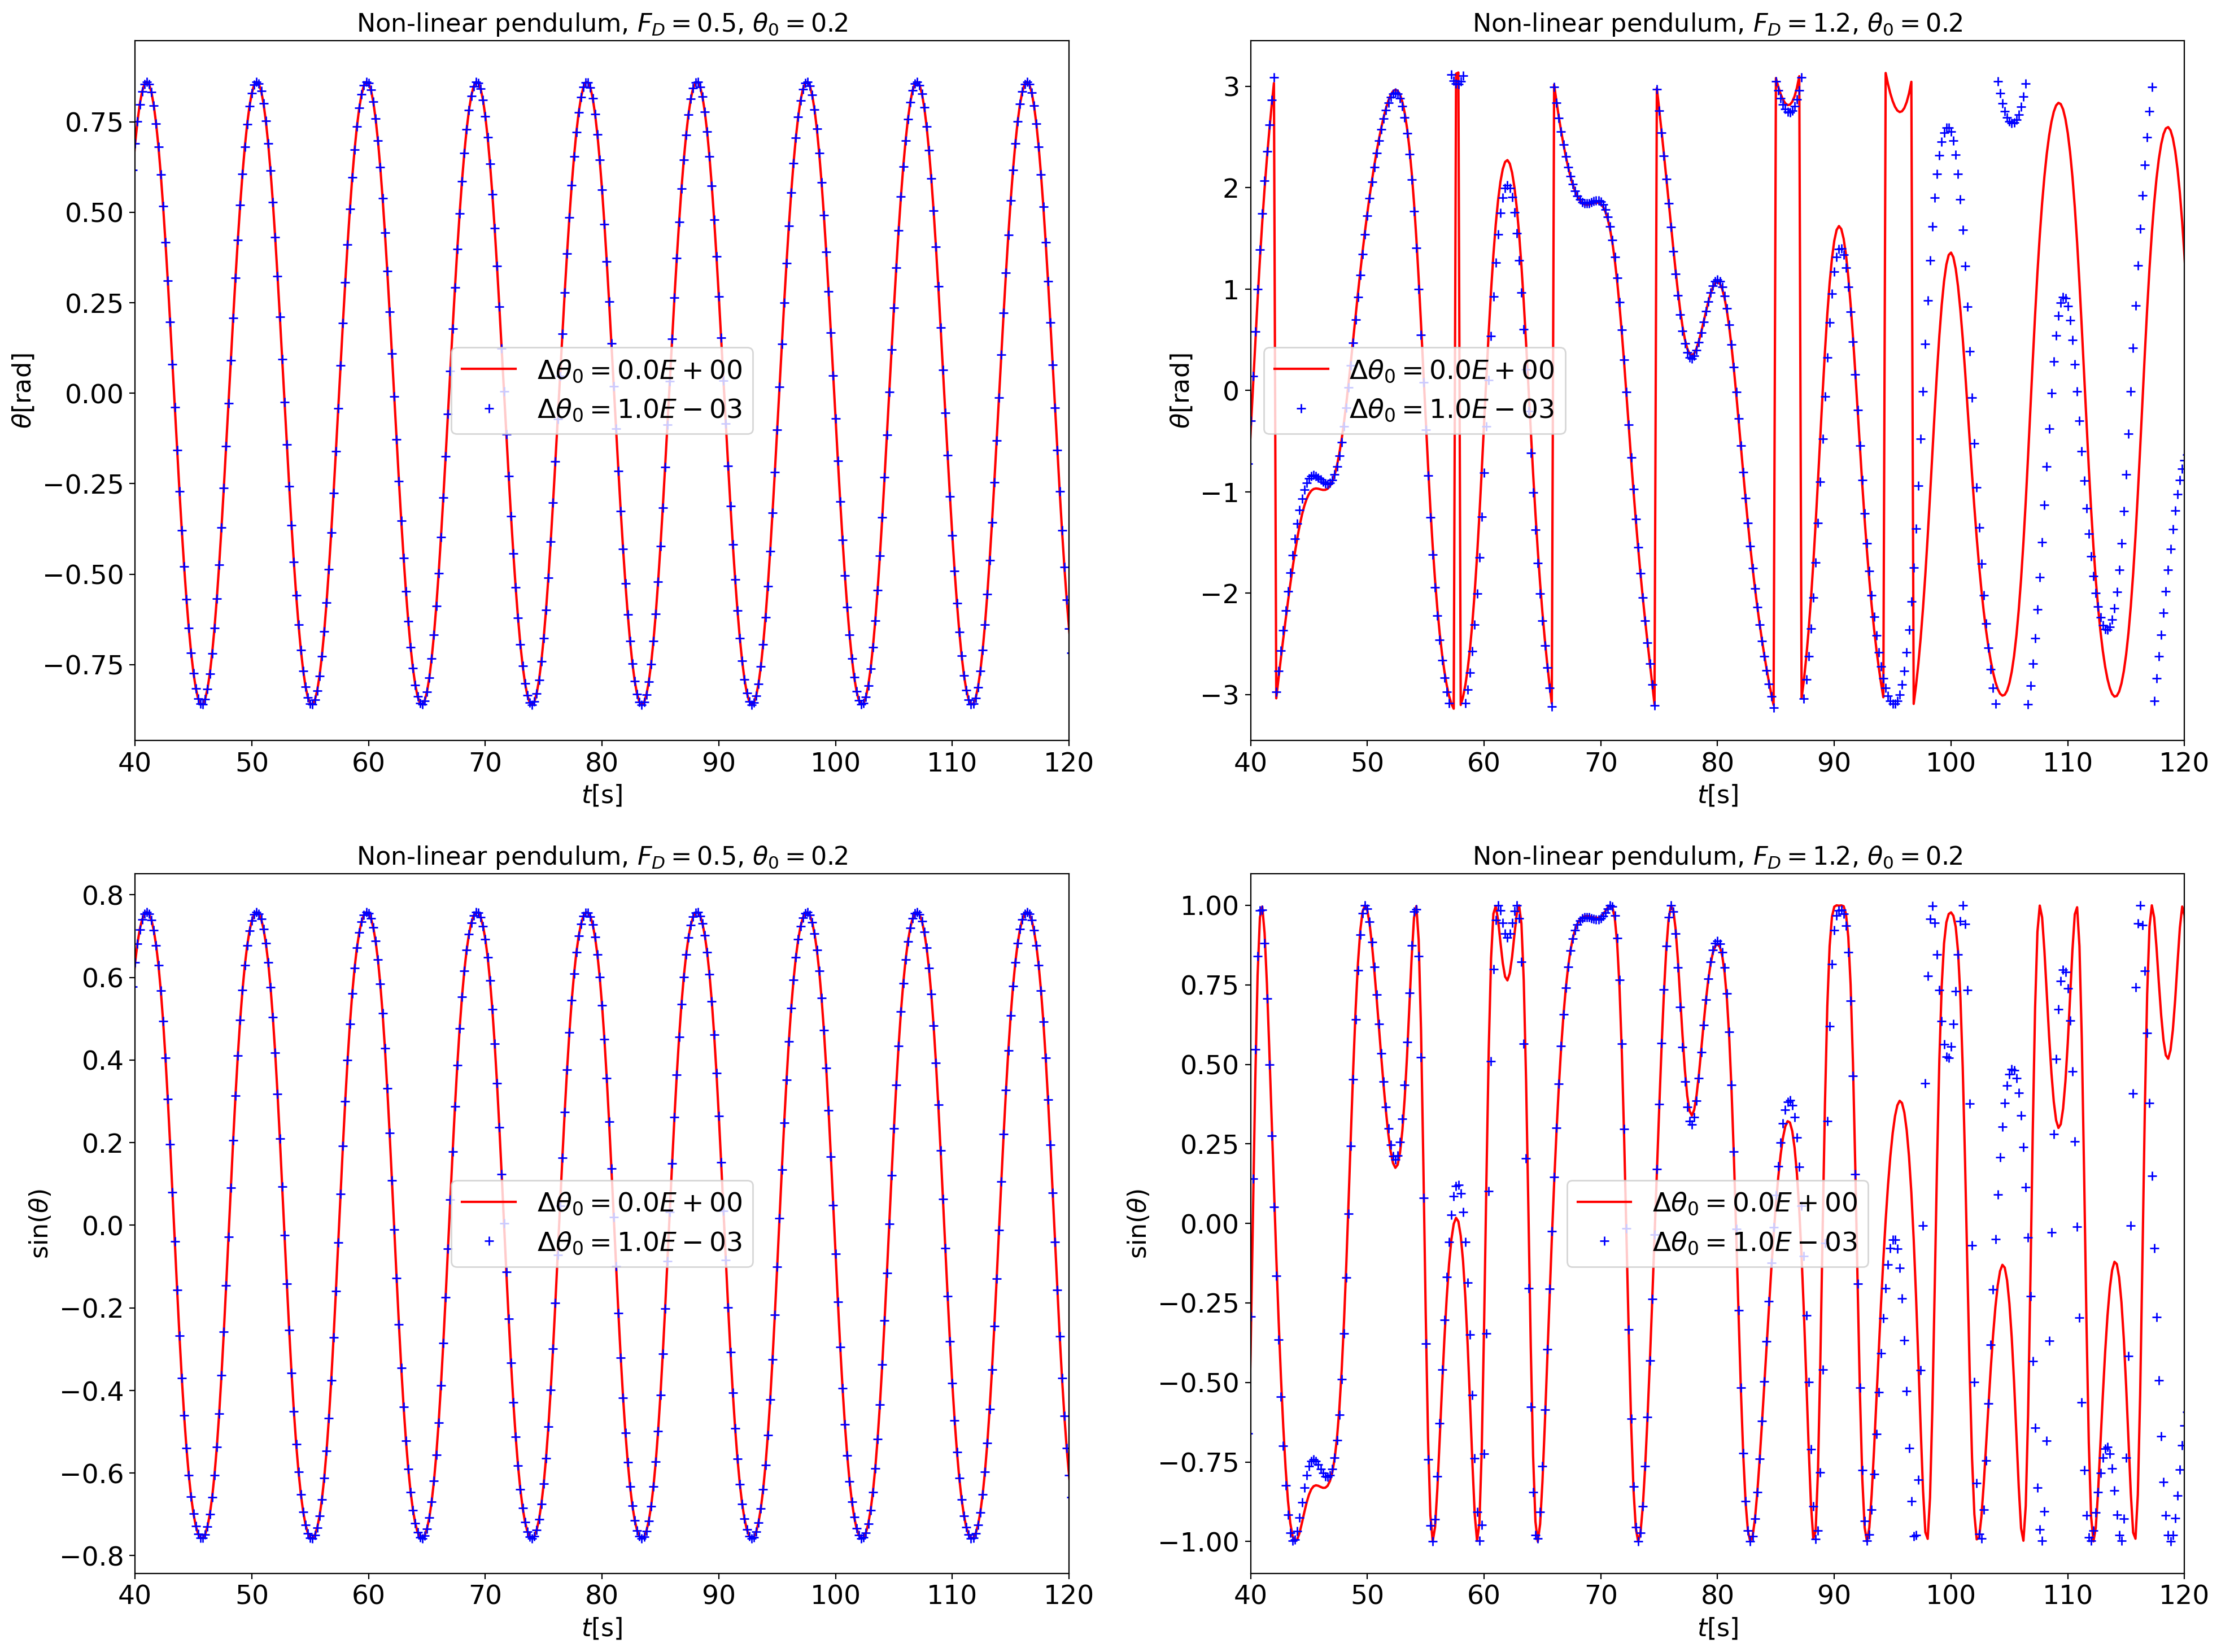

In [23]:
# Write a figure caption. Make sure it describes all the curves.
# Write the caption as code comments - i.e start each line with a "#"
#
# marking scheme:     correct description of what is on the axes:     2 marks
#                    correct description of what is plotted:         2 marks
#                    description is succinct:                        1 mark
# YOUR CODE HERE

# Top left:
# The plot shows the evolution of the angular displacement($\theta(t)$), for the non-linear pendulum with a drving force $F_D = 0.5$.
# The red line represents the trajectory for initial angle $\theta_0 = 0.2$
# The blue crosses represent the trajectory for small step size of $\Delta\theta_0$

# Top Right:
# The plot shows the evolution of the angular displacement($\theta(t)$), for the non-linear pendulum with a drving force $F_D = 1.2$.
# The red line represents the trajectory for initial angle $\theta_0 = 0.2$
# The blue crosses represent the trajectory for small step size of $\Delta\theta_0$

# Bottom left:
# The plot shows the evolution of the sine of the angular displacement($\sin(\theta(t）)$), for the non-linear pendulum with a drving force $F_D = 0.5$.
# The red line represents the trajectory for initial angle $\theta_0 = 0.2$
# The blue crosses represent the trajectory for small step size of $\Delta\theta_0$

# Bottom Right:
# The plot shows the evolution of the sine of the angular displacement($\sin(\theta(t）)$), for the non-linear pendulum with a drving force $F_D = 1.2$.
# The red line represents the trajectory for initial angle $\theta_0 = 0.2$
# The blue crosses represent the trajectory for small step size of $\Delta\theta_0$

# For TL and TR, BL and BR, they are significant deviations, the sensitivity of the system is high.


## Lyapunov exponents

When the pendulum is **not** chaotic, the evolution of two identical pendulums that start from slightly different launch angles, $\theta_0$, remains close, meaning

$|\Delta \theta(t)|=|\theta_1(t)-\theta_2(t)|$

remains small. This is the case for $F_D=0.5$. 

In contrast, when the pendulum **is** chaotic, $|\Delta \theta(t)|$ increases rapidly with $t$, until it saturates, because $\theta_1$ and $\theta_2$ become uncorrelated.

Plot $\ln|\Delta \theta(t)|$ versus time for the two cases discussed before (i.e. $F_D=0.5$ and $F_D=1.2$).
Use the plot labeling in the cell below. 

Note: $\ln$ denotes the natural logarithm, as opposed to $\log\equiv \log_{10}$ which is base 10.

**5 marks**



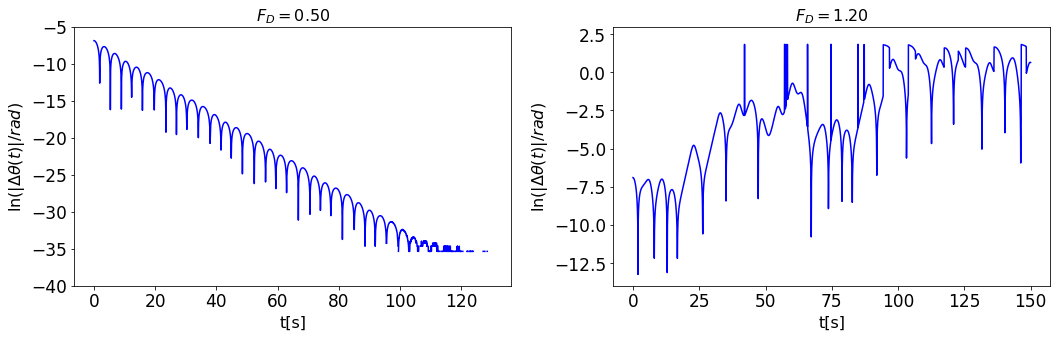

In [25]:
# Plot evolution of ln|Delta theta| between the two pendulums as a function of time, 
# for the two values of F_D in two panels.
# Left panel: case F_D=0.5, right panel: case F_D=1.2


# Approximate marking scheme
# two panels are plotted:     2 marks
# axes are labelled:          2 marks
# value of F_D is indicated   2 marks
# curves looks OK              4 marks
# YOUR CODE HERE

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, F_D in enumerate(F_D_values):
    pendulum1 = Pendulum(L, q, F_D, Omega_D, nonlinear)
    pendulum2 = Pendulum(L, q, F_D, Omega_D, nonlinear)
    
    x0_1 = np.array([theta0, 0])
    x0_2 = np.array([theta0 + dtheta0, 0])
    
    solver1 = EulerCromerSolver(pendulum1)
    solver2 = EulerCromerSolver(pendulum2)
    
    solver1.solve(x0_1, t0, t1, dt)
    solver2.solve(x0_2, t0, t1, dt)
    
    ts1 = solver1.timeSteps()
    ts2 = solver2.timeSteps()
    theta1, _ = solver1.coordinateSteps()
    theta2, _ = solver2.coordinateSteps()
    theta1 = (theta1 + np.pi) % (2 * np.pi) - np.pi
    theta2 = (theta2 + np.pi) % (2 * np.pi) - np.pi
    
    delta_theta = np.abs(theta1 - theta2)
    safe_delta_theta = np.where(delta_theta > 1e-20, delta_theta, np.nan)
    ln_delta_theta = np.log(safe_delta_theta)
    
    ax[i].plot(ts1, ln_delta_theta, 'b-')
    ax[i].set_xlabel("t[s]")
    ax[i].set_ylabel(r"$\ln(|\Delta \theta(t)|/rad)$")
    ax[i].set_title(f"$F_D = {F_D:.2f}$")
ax[0].set_ylim([-40,-5])
ax[1].set_ylim([-14,3])
plt.tight_layout()
plt.show()


You may want to compare your results to the plot below. Note how individual panels have the value of $F_D$
in the title.


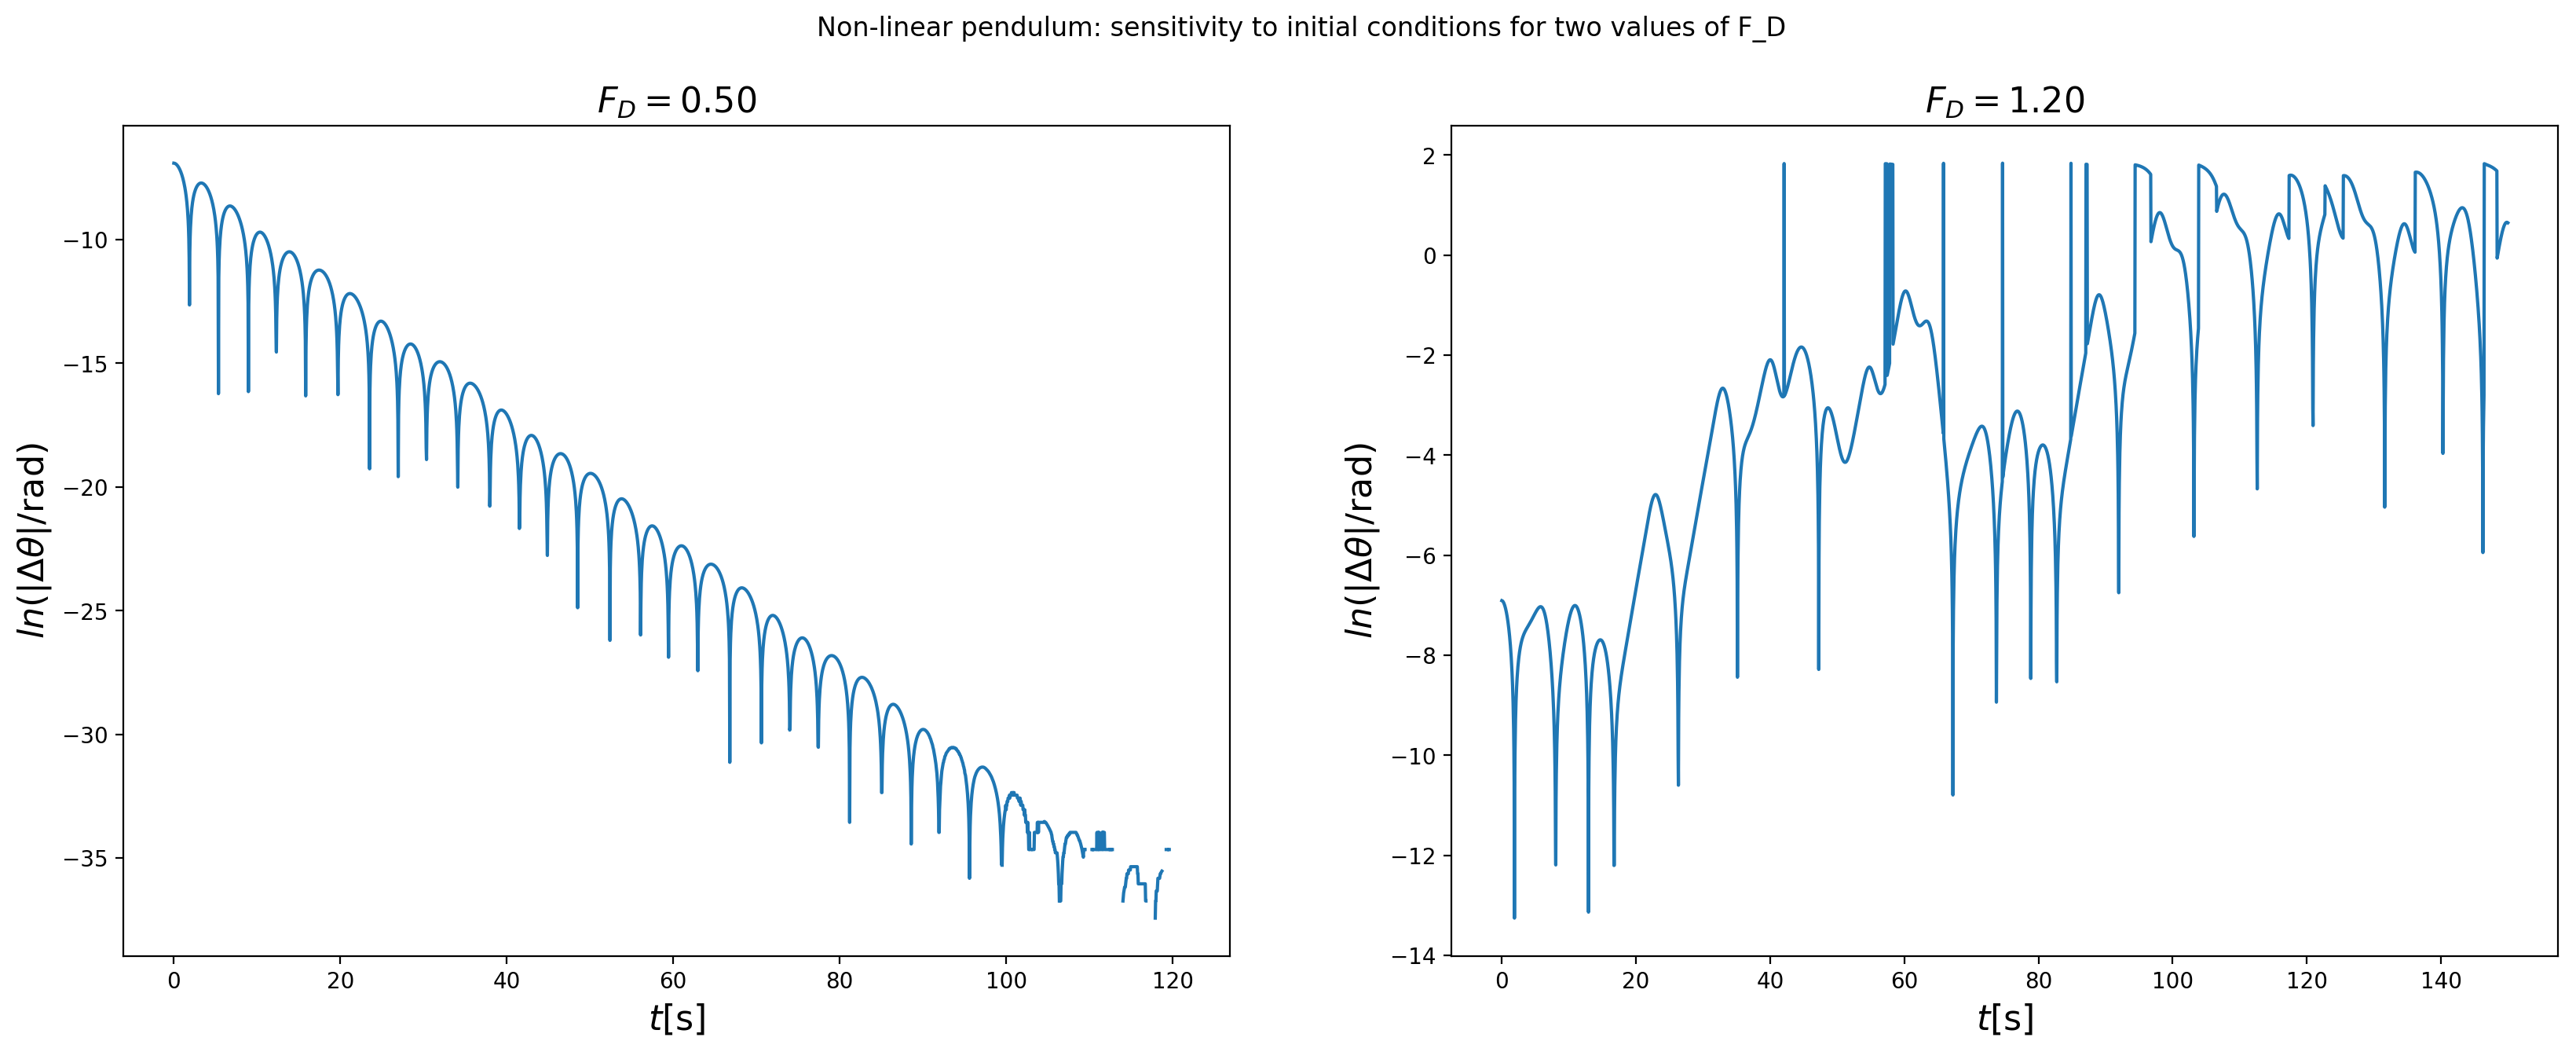


In [14]:
# Write a figure caption for these figures
# Write the caption as code comments - i.e start each line with a "#"
# marking scheme:     correct description of what is on the axes:     2 marks
#                     correct description of what is plotted:         2 marks
#                     description is succinct:                        1 mark

# YOUR CODE HERE

# Left:
# The plot shows the logarithm of the absolute difference between the angular displacement($|\Delta\theta(t)| = |\theta_1(t) - \theta_2(t)|$), for the non-linear pendulum with driving force($F_D = 0.5$)
# The x-axis represents time in seconds. The y-axis represents $\ln(|\Delta\theta(t)|)$

# Right
# The plot shows the logarithm of the absolute difference between the angular displacement($|\Delta\theta(t)| = |\theta_1(t) - \theta_2(t)|$), for the non-linear pendulum with driving force($F_D = 1.2$)
# The x-axis represents time in seconds. The y-axis represents $\ln(|\Delta\theta(t)|)$

# For L and R, they are significant deviations, the sensitivity of the system is high.


### Computing the Lyapunov exponents

To compute the Lyapunov exponents, we need to fit a straight line through a set of points. The cell below 
performs such a fit by invoking the numpy function `polyfit`.


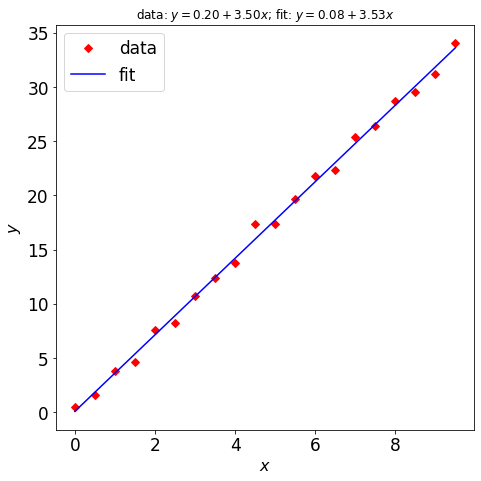

In [15]:
# Example of fitting data with a straight line using polyfit
#
x = np.arange(0, 10, 0.5)
a = 0.2
b = 3.5
y = a + b * x                                     # linear relation to be recovered

# add some small scatter
np.random.seed(12)                                    # set random seed
y += np.random.normal(0, 0.5, len(y))                 # Gaussian distributed scatter

# fit with first-order polynomial (straight line)
c1, c0     = np.polyfit(x, y, 1)
label      = r"data: $y={0:1.2f}+{1:1.2f} x$; fit: $y={2:1.2f}+{3:1.2f} x$".format(a,b, c0, c1)
# 
fit = c0 + c1 * x


fig, ax = plt.subplots(1, 1, figsize = (7, 7))
ax.plot(x, y, 'D', color='red', label='data')
ax.plot(x, fit, '-', color='blue', label='fit')
ax.set_title(label,fontsize=12)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.tight_layout()
fig.show()


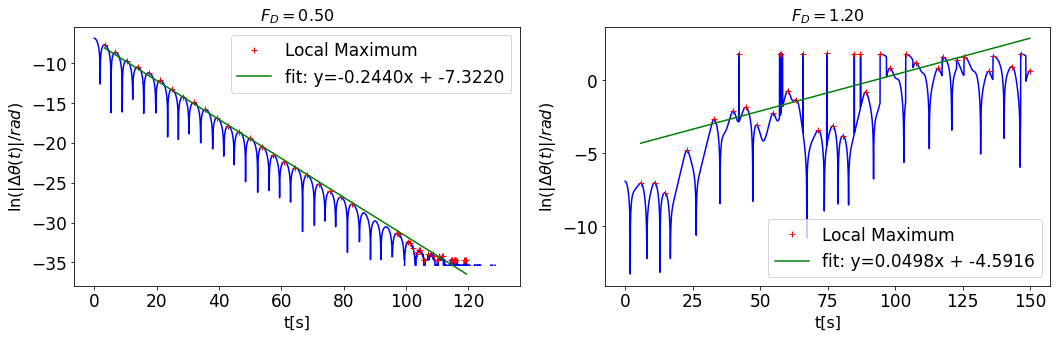

-0.24395482946173988
0.04984772231920734


In [16]:
# Fit a straight line to local maxima to estimate the value of Lyapunov exponents in both cases

# Plot the evolution of ln(|Delta theta|) as a function of time
#   label the plot (for both cases) and label the axes
#   you may want to re-use the code you wrote earlier
#  Next:
#  plot the points to which you are fitting a straight line to infer the Lyapunov exponent
#  overplot the fit
#  Use a legend to clarify which is the data and which is the fit

# Approximate marking scheme
# panels from before are reproduced (including labels):    2 marks
# maxima are correctly computed and indicated:             4 marks
# fit is overplotted:                                      2 marks
# fit looks OK                                             2 marks


# Note that, in the chaotic case, the two angles eventually become uncorrelated. 
# Take this into account when determining the range over which you should fit the data 
#    (i.e the log of the absolute value of the difference between the two angles as a function of time)
# This is the hard part: determining which part of the curve should be fitted.


# Then answer the questions below
# YOUR CODE HERE

def find_local_maxima(y_vals, t_vals):
    maxima = []
    maxima_times = []
    for i in range(1, len(y_vals)-1):
        if y_vals[i] > y_vals[i-1] and y_vals[i] > y_vals[i+1]:
            maxima.append(y_vals[i])
            maxima_times.append(t_vals[i])
    return maxima, maxima_times

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, F_D in enumerate(F_D_values):
    pendulum1 = Pendulum(L, q, F_D, Omega_D, nonlinear)
    pendulum2 = Pendulum(L, q, F_D, Omega_D, nonlinear)
    
    x0_1 = np.array([theta0, 0])
    x0_2 = np.array([theta0 + dtheta0, 0])
    
    solver1 = EulerCromerSolver(pendulum1)
    solver2 = EulerCromerSolver(pendulum2)
    
    solver1.solve(x0_1, t0, t1, dt)
    solver2.solve(x0_2, t0, t1, dt)
    
    ts1 = solver1.timeSteps()
    ts2 = solver2.timeSteps()
    theta1, _ = solver1.coordinateSteps()
    theta2, _ = solver2.coordinateSteps()
    theta1 = (theta1 + np.pi) % (2 * np.pi) - np.pi
    theta2 = (theta2 + np.pi) % (2 * np.pi) - np.pi
    
    delta_theta = np.abs(theta1 - theta2)
    safe_delta_theta = np.where(delta_theta > 1e-20, delta_theta, np.nan)
    ln_delta_theta = np.log(safe_delta_theta)
    
    ax[i].plot(ts1, ln_delta_theta, 'b-')
    ax[i].set_xlabel("t[s]")
    ax[i].set_ylabel(r"$\ln(|\Delta \theta(t)|/rad)$")
    ax[i].set_title(f"$F_D = {F_D:.2f}$")

    maxima, maxima_times = find_local_maxima(ln_delta_theta, ts1)
    
    if len(maxima) > 0:
        maxima = np.array(maxima)
        maxima_times = np.array(maxima_times)
        
        c1, c0 = np.polyfit(maxima_times, maxima, 1) 
        fit = c0 + c1 * maxima_times
        
        ax[i].plot(maxima_times, maxima, 'r+', label="Local Maximum")
        ax[i].plot(maxima_times, fit, 'g-', label=f"fit: y={c1:.4f}x + {c0:.4f}")
        ax[i].legend()
        
        if F_D == 0.5:
            lyapunov_nonchaotic = c1
        elif F_D == 1.2:
            lyapunov_chaotic = c1
    
plt.tight_layout()
plt.show()

print(f"{lyapunov_nonchaotic}")
print(f"{lyapunov_chaotic}")


Enter your answers in the **two boxes** below. 
If they do not appear, run the hidden cells below to make them appear.



In [30]:
chaos0=myFloatBox('chaos0',r"$\lambda_{\rm nonchaotic}=$","Estimate the Lyapunov exponent $\lambda$ for the non-chaotic case."
               " Your value should be accurate to within a factor of 2")
chaos0.getWidget()

In [31]:
chaos1=myFloatBox('chaos1',r"$\lambda_{\rm chaotic}=$","Estimate the Lyapunov exponent $\lambda$ for the chaotic case."
               " Your value should be accurate to within a factor of 2")
chaos1.getWidget()

## Phase-space diagram

Next we examine the phase-space diagram of a non-linear pendulum

For the same parameters of the non-linear pendulum as used before, we will make a `phase-space diagram`. Do so for the two values of the driving amplitude as before that we used earlier


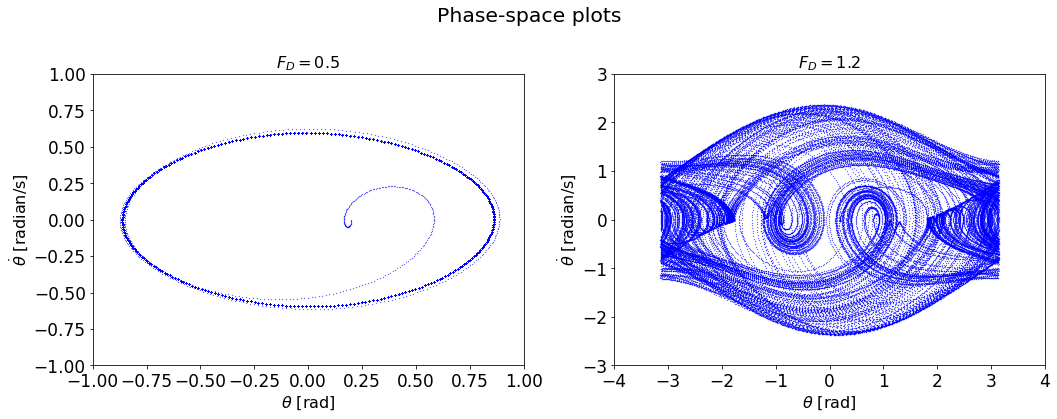

In [35]:
# For the same parameters of the non-linear pendulum, make a phase-space diagram
#    for the same two values of the driving amplitude as before

F_Ds        = [0.5,1.2]     # For these two values of driving amplitude

# The next lines uses the Period of the driving force (called Period)
# We specify the end of the calculation in units of the Period, computed already in one of the previous cells
t1          = 200 * Period         # end time of the calculation
NperPeriod  = 300           
dt          = Period / NperPeriod  # Set time-step as a fraction of the period

# make two plots:
#  left panel:  phase-space diagram for F_D = 0.5, 
#  right panel: phase-space diagram for F_D = 1.2
#    (the two values of the driving amplitude that we have been using so far)
#  make sure to add axes labels, and annotate the plots with the value of F_D

# You may want to store the evolution for each case, since we will make more plots from the computed
#    evolution

# YOUR CODE HERE

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i, F_D in enumerate(F_Ds):
    pendulum = Pendulum(L, q, F_D, Omega_D, nonlinear=True)
    
    x0 = np.array([theta0, 0])
    
    solver = EulerCromerSolver(pendulum)
    
    solver.solve(x0, t0, t1, dt)
    
    ts = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps()
    theta = (theta + np.pi) % (2 * np.pi) - np.pi
    
    ax[i].plot(theta, dtheta_dt, 'b.', markersize=0.5)
    ax[i].set_xlabel(r'$\theta$ [rad]')
    ax[i].set_ylabel(r'$\dot{\theta}$ [radian/s]')
    ax[i].set_title(f"$F_D = {F_D}$")
    
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[1].set_xlim([-4,4])
ax[1].set_ylim([-3,3])
fig.suptitle("Phase-space plots")
plt.tight_layout()
plt.show()

You may want to compare your results to the plot below. Note how individual panels have titles.
Also, I used a `.` for each point in the left panel: otherwise the image is too faint. But I used a `,` for the data points in the right panel: otherwise you can't see the intricate structure.

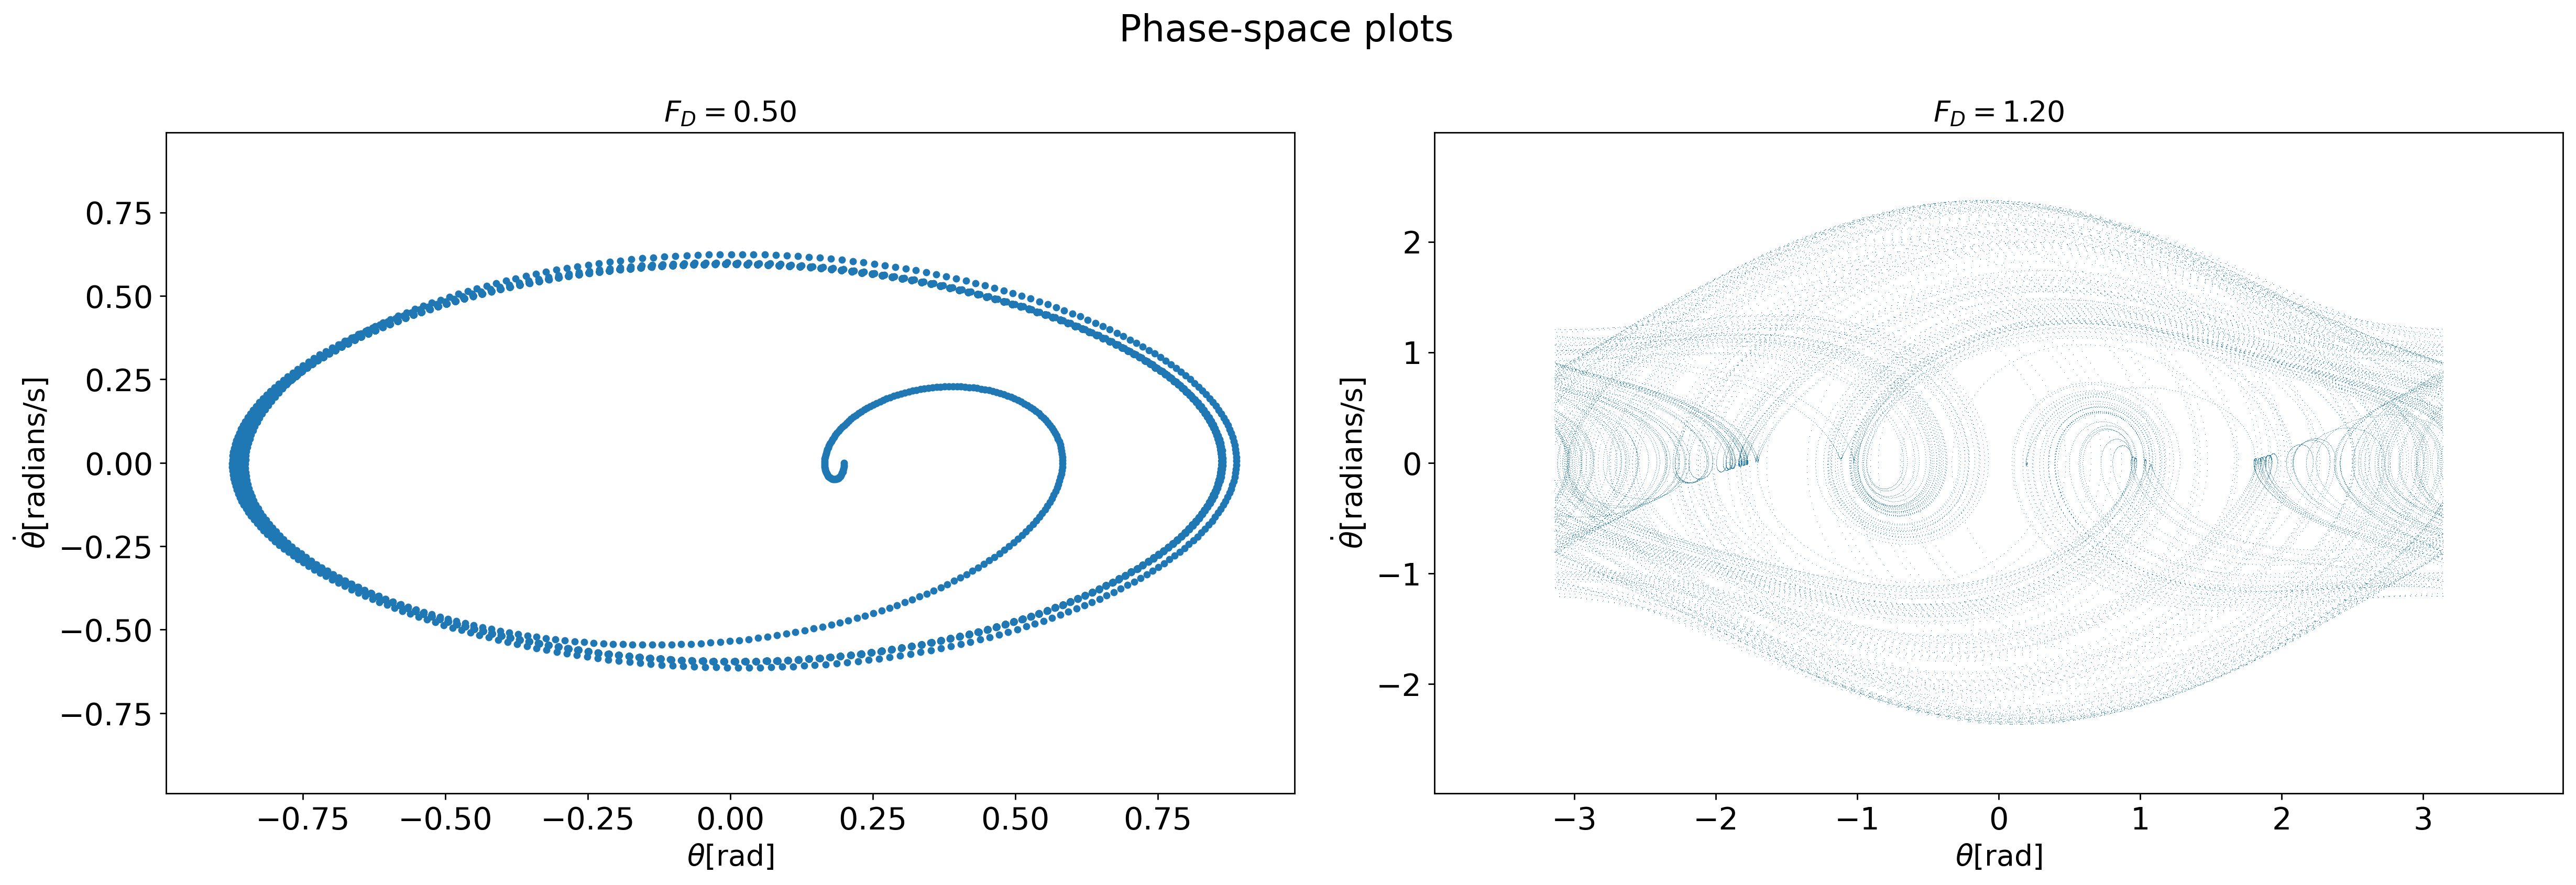



Extract from the phase-diagram those points for which $\Omega_D t$ is $2N\pi$, where $N$ is an integer.
Use this subset to make a Poincare section, for both values of the driving force. Make sure to label the axes.

**5 marks**

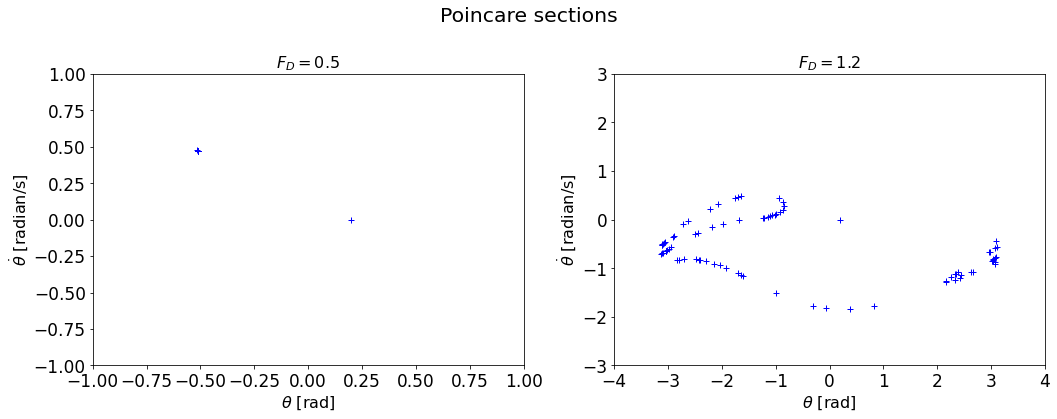

In [20]:
# Extract Poincar\'e section, by making a phase-space diagram but selecting those points
# for which Omega_D t = N 2pi, where N is an integer


# YOUR CODE HERE

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i, F_D in enumerate(F_Ds):
    pendulum = Pendulum(L, q, F_D, Omega_D, nonlinear=True)
    
    x0 = np.array([theta0, 0])
    
    solver = EulerCromerSolver(pendulum)
    
    solver.solve(x0, t0, t1, dt)
    
    ts = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps()
    theta = (theta + np.pi) % (2 * np.pi) - np.pi
    
    poincare_indices = np.where(np.isclose(Omega_D * ts % (2 * np.pi), 0, atol=1e-3))[0]
    poincare_theta = theta[poincare_indices]
    poincare_dtheta_dt = dtheta_dt[poincare_indices]
    
    ax[i].plot(poincare_theta, poincare_dtheta_dt, 'b+')
    ax[i].set_xlabel(r'$\theta$ [rad]')
    ax[i].set_ylabel(r'$\dot{\theta}$ [radian/s]')
    ax[i].set_title(f"$F_D = {F_D}$")

ax[0].set_xlim([-1,1])
ax[1].set_xlim([-4,4])
ax[0].set_ylim([-1,1])
ax[1].set_ylim([-3,3])
fig.suptitle("Poincare sections")
plt.tight_layout()
plt.show()


You may want to compare your results to the plot below. Note how individual panels have the value of $F_D$
in the title.


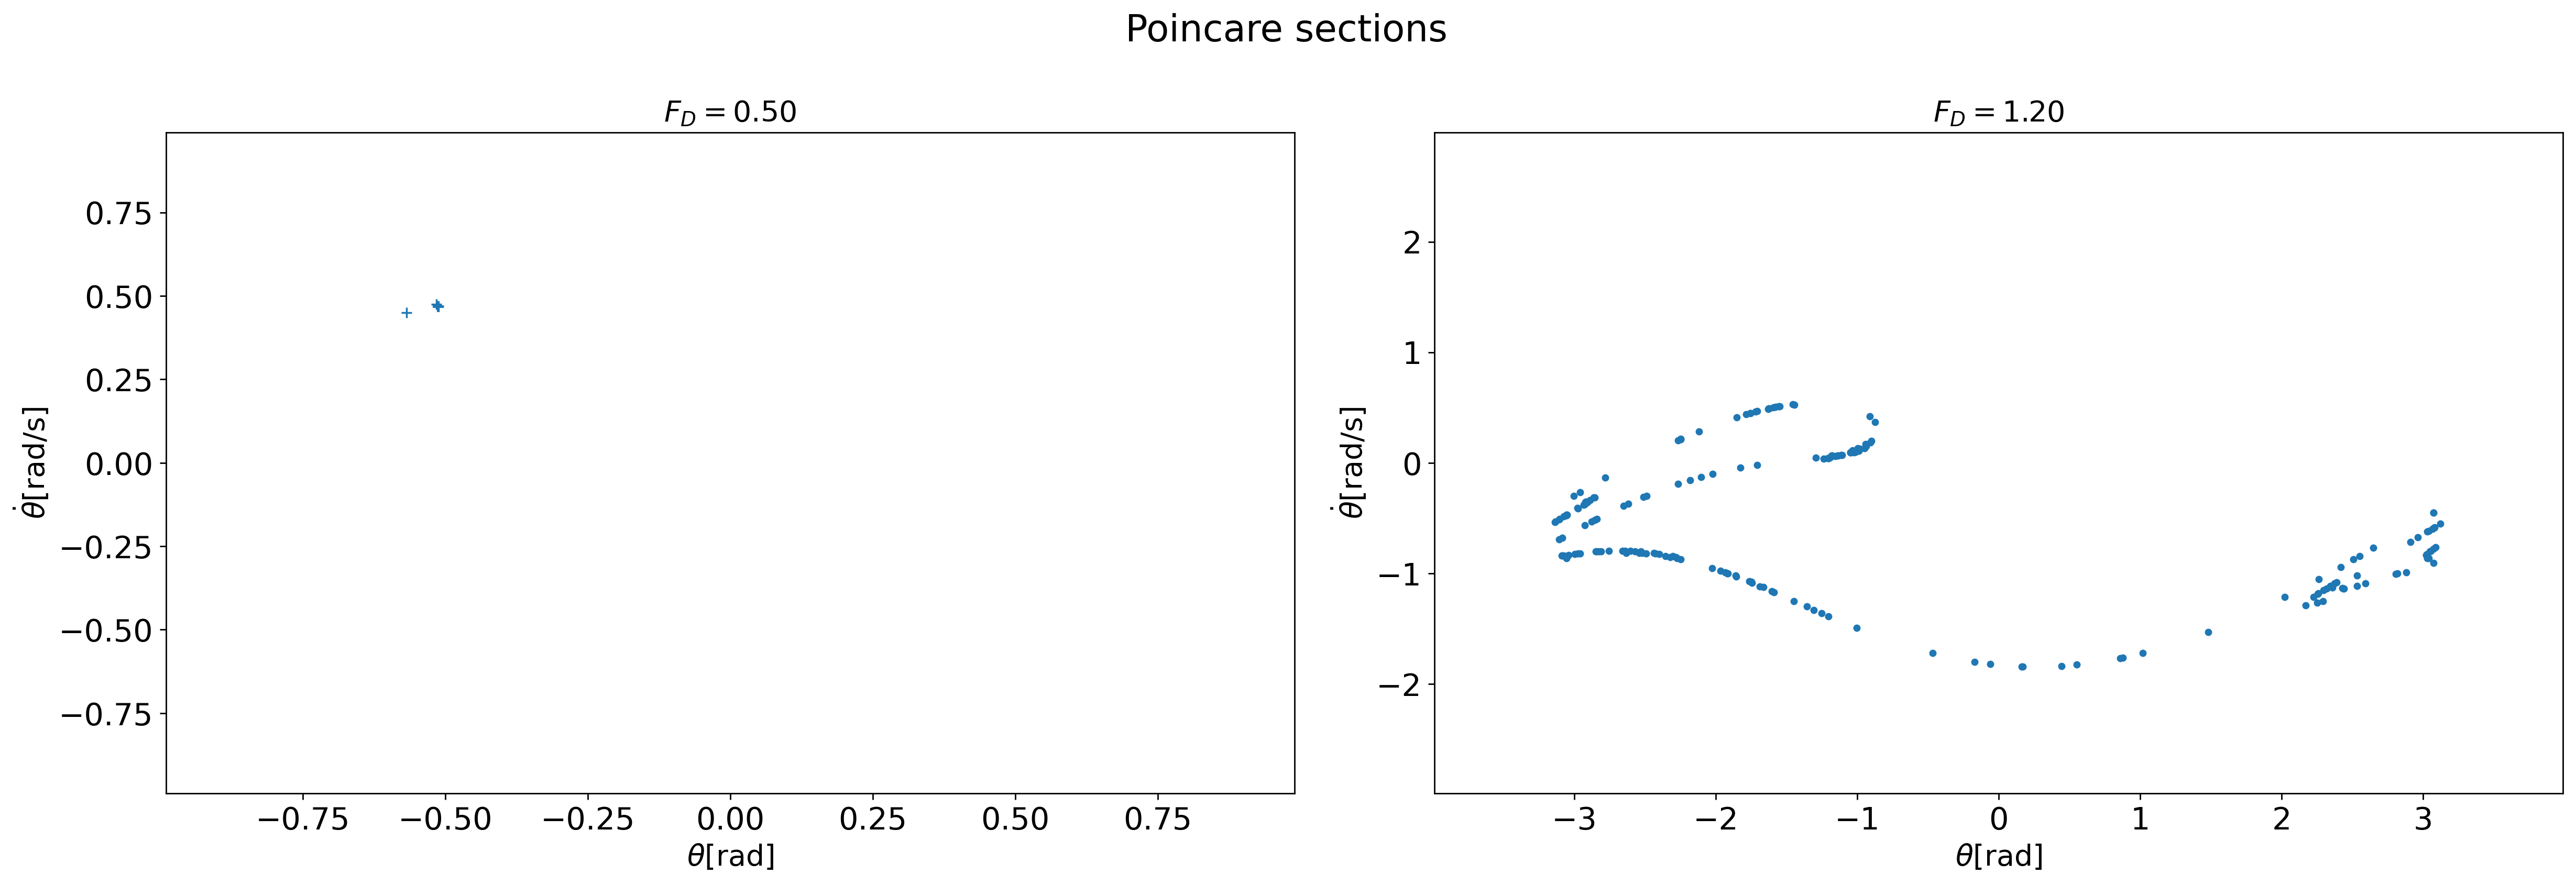

## Compute the bifurcation diagram for the non-linear pendulum

**5 marks**


We will compute the evolution of the non-linear pendulum for a range of amplitudes, F_D, of the driving force. We pick values of F_D such that they sample more finely the region where period doubling occurs.

In [93]:
# Use this cell to perform the calculation and store the result
# Make sure you pick only the values of (theta, dtheta_dt) that your are going to plot to save memory
# We will use the next cell to plot the results

# Calculate evolution for the following values of the amplitude of the driving force
FD1        = np.arange(1.35, 1.47 , 0.005)
FD2        = np.arange(1.471, 1.488 , 0.001)   # sample the interesting region more finely
F_Ds       = np.concatenate([FD1, FD2])

# Run the pendulum for each value in F_Ds, from t0 = 0, to t1 = 400 Periods
# Use a timestep equal to the period of the driving force divided by 300
# Plot the bifurcation diagram from t = 300 Periods, to t=400 Periods
# The calculations in this cell may take a minute or two to complete. That's why it is usefull to
#   perform the calculation in one cell and make the plot in another cell: if you needed
#   to change something to the plot (labels, limits, etc), then there is no need to perform 
#   the calculation again.

NperPeriod = 300                  # Number of steps per period
dt         = Period / NperPeriod  # time step
t1         = 400*Period           # final time
Prec       = 300                  # store results from Pred periods on

# we time the computation
start_time = time.time()

# We store the results in a dictionary
soln       = {}

# YOUR CODE HERE

for F_D in F_Ds:
    pendulum = Pendulum(L, q, F_D, Omega_D, nonlinear=True)
    
    x0 = np.array([theta0, 0])
    
    solver = EulerCromerSolver(pendulum)
    
    solver.solve(x0, 0, t1, dt)
    
    ts = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps()
    theta = (theta + np.pi) % (2 * np.pi) - np.pi

    valid_indices = np.where(ts > 300 * Period)[0]
    soln[F_D] = (theta[valid_indices], dtheta_dt[valid_indices])

cpu_time = time.time() - start_time
print(" Calculation finished, cpu time used [s] = ", cpu_time)       

 Calculation finished, cpu time used [s] =  48.844189167022705


Plot your results using the cell below

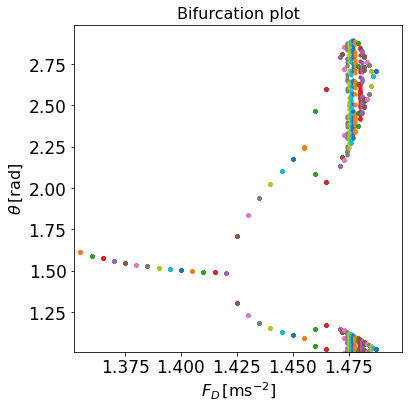

In [94]:
# Bifurcation plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.set_title('Bifurcation plot')
ax.set_xlabel(r'$F_D\,[\mathrm{m s^{-2}}]$')
ax.set_ylabel(r'$\theta\,[\mathrm{rad}]$')
ax.set_xlim(1.352, 1.499)
ax.set_ylim(1.01, 2.99)

# select those times, where Omega_D t = n 2 pi
# YOUR CODE HERE

for F_D in F_Ds:
    theta_vals, _ = soln[F_D]
    
    ax.plot(F_D * np.ones_like(theta_vals)[::300], theta_vals[::300], '.')

plt.tight_layout()
plt.show()

You may want to compare your results to the plot below.

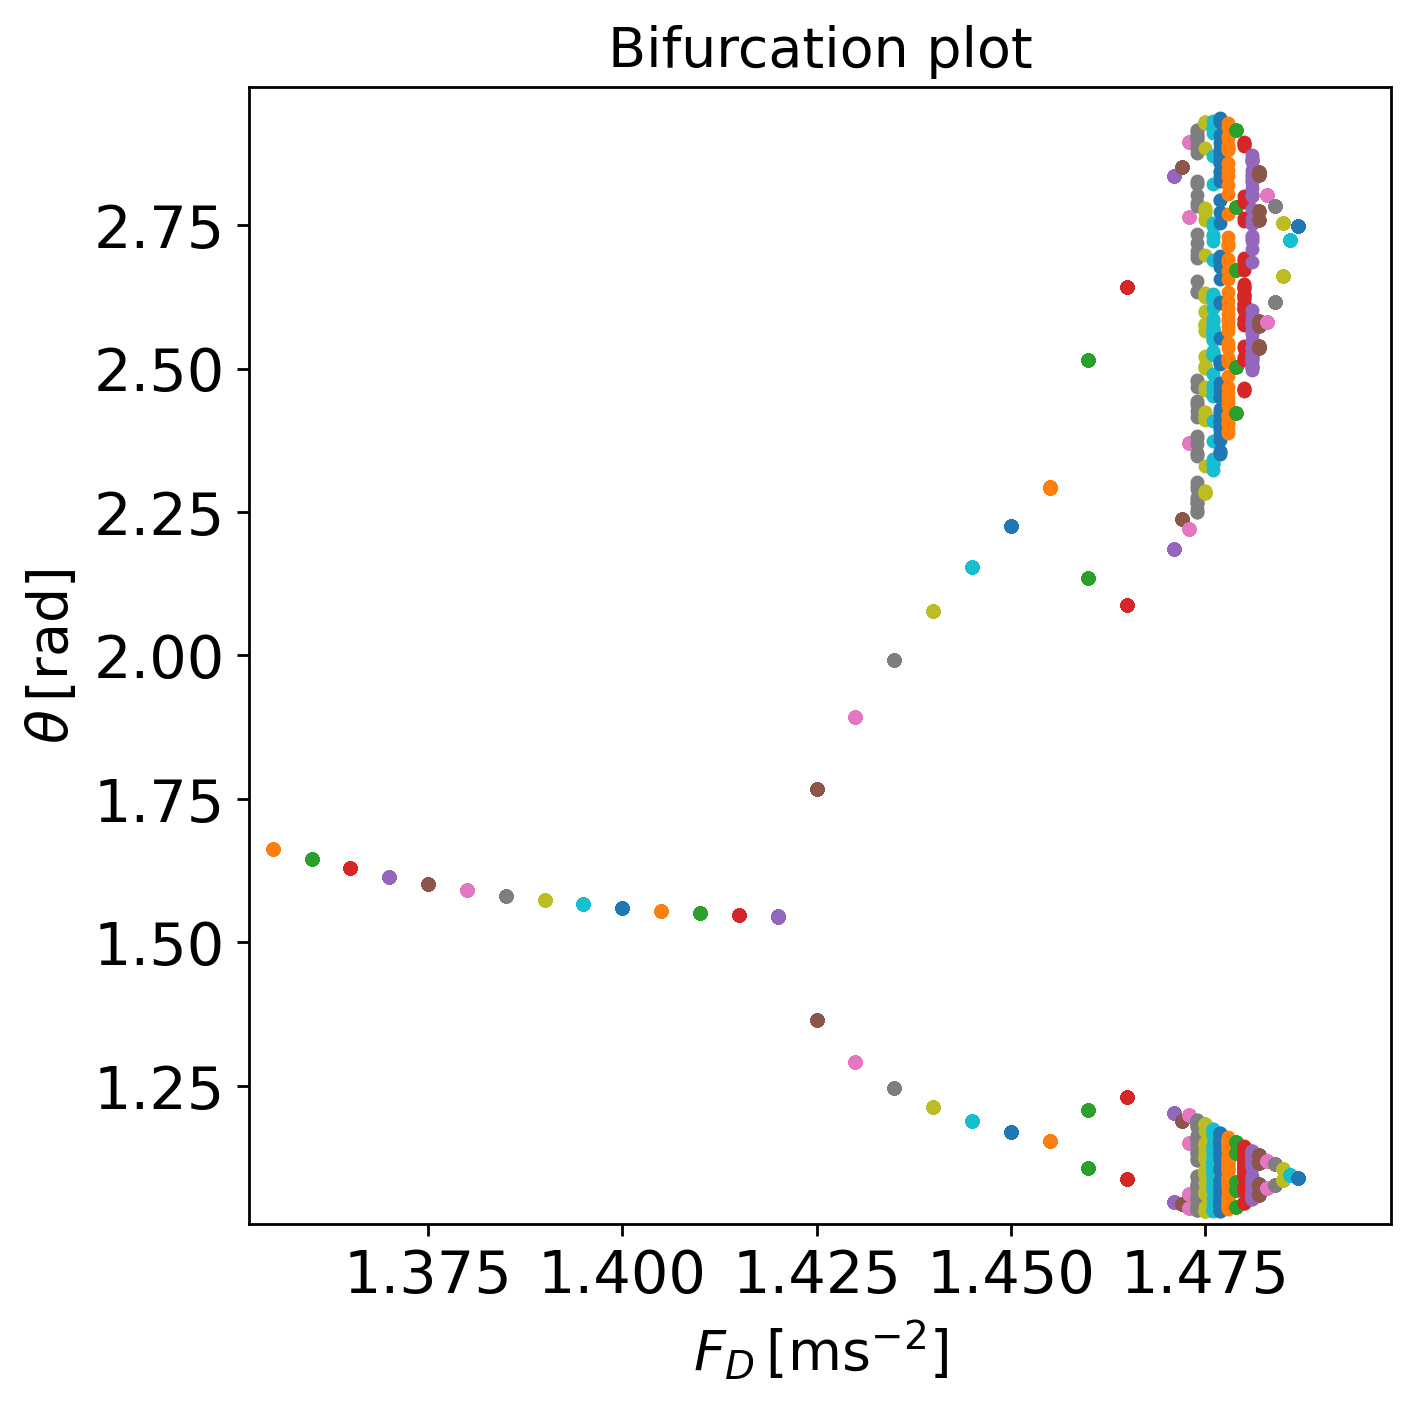

## Playground

Investigate how the bifurcation diagram changes if you

 - plot $\theta(t)$ when $\Omega_D t = \pi + n 2\pi$
 
 - plot $\dot\theta$ on the $y$-axis rather than $\theta$